In [ ]:
# Physics Informed Neural Networks

# **Zero Shot Method for Exponential Decay**

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim

class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)


    def derivative(self, y, x):
        return grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]


    def physics_loss(self, x):
        x = x.requires_grad_(True)

        u = self.forward(x)
        du_dx = self.derivative(u, x)
        residual = du_dx + torch.exp(-x)

        return torch.mean(residual**2)

    def train_step(self, x_phys):
        self.optimizer.zero_grad()
        loss = self.physics_loss(x_phys)
        loss.backward()
        self.optimizer.step()
        return loss.item()


In [ ]:
pinn = PINN()

for epoch in range(2000):
    x = torch.linspace(0, 10, 50).unsqueeze(1)
    loss = pinn.train_step(x)

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6f}")


Epoch 0: Loss = 0.057011
Epoch 200: Loss = 0.000027
Epoch 400: Loss = 0.000003
Epoch 600: Loss = 0.000001
Epoch 800: Loss = 0.000001
Epoch 1000: Loss = 0.000000
Epoch 1200: Loss = 0.000000
Epoch 1400: Loss = 0.000000
Epoch 1600: Loss = 0.000000
Epoch 1800: Loss = 0.000000


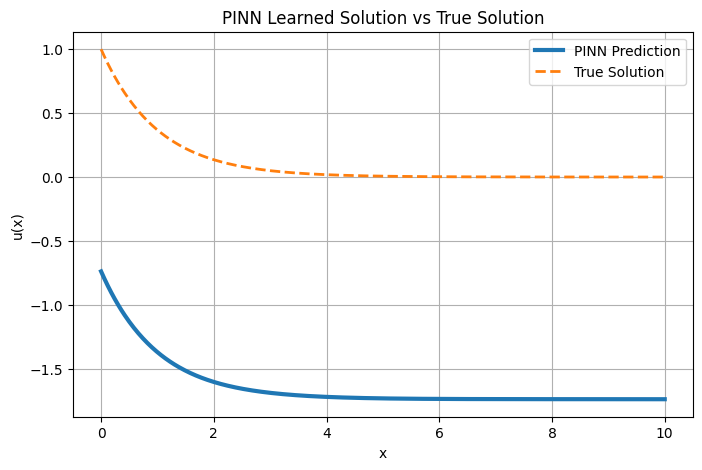

In [ ]:
import matplotlib.pyplot as plt

x_test = torch.linspace(0, 10, 500).unsqueeze(1)
u_pred = pinn.forward(x_test).detach()

# True analytical solution: u(x) = e^{x}
u_true =torch.exp(-x_test)

plt.figure(figsize=(8,5))
plt.plot(x_test.numpy(), u_pred.numpy(), label="PINN Prediction", linewidth=3)
plt.plot(x_test.numpy(), u_true.numpy(), '--', label="True Solution", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN Learned Solution vs True Solution")
plt.legend()
plt.grid(True)
plt.show()

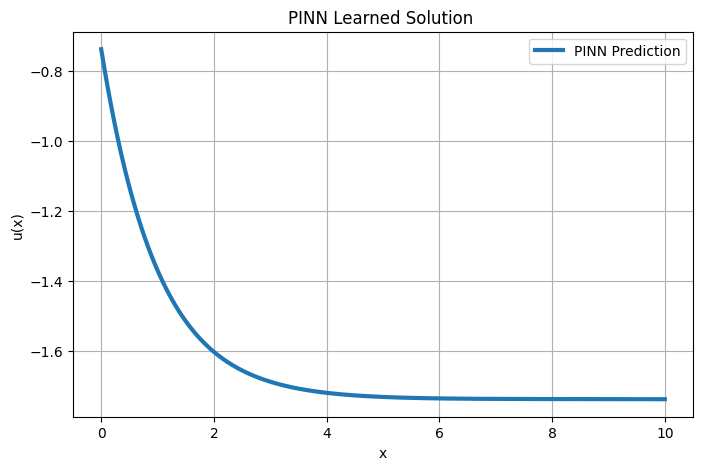

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(x_test.numpy(), u_pred.numpy(), label="PINN Prediction", linewidth=3)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN Learned Solution ")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#PINN for SHM
# we will modify the previos code with a new definition of physics loss and a new definition of second derivative
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim

class PINN(nn.Module):
    def __init__(self,omega,beta):
        super().__init__()
        self.omega = omega
        self.beta = beta
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)


    def derivative(self, y, x):
        return grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]

    def second_derivative(self, y, x):
        du_dx = self.derivative(y, x)
        u_xx = self.derivative(du_dx, x)
        return u_xx

    def physics_loss(self, x):
        x = x.requires_grad_(True)
        u = self.forward(x)
        du_dt = self.derivative(u, x)
        d2u_dt2 = self.derivative(du_dt, x)

        beta = self.beta      # damping coefficient
        omega = self.omega    # natural frequency

        # Residual of damped SHM equation
        residual = d2u_dt2 + 2 * beta * du_dt + omega**2 * u

        # Physics loss = MSE of residual
        return torch.mean(residual**2)

    def data_loss(self, x0, u0, v0): # add another data loss basically takes into account the initial position
        x0 = x0.requires_grad_(True)

        u_pred = self.forward(x0)
        du_pred = self.derivative(u_pred, x0)

        loss_u = torch.mean((u_pred - u0)**2)
        loss_v = torch.mean((du_pred - v0)**2)

        return loss_u + loss_v


    def train_step(self, x_phys, x0, u0, v0, lambda_data=1.0):
        self.optimizer.zero_grad()

        loss_phys = self.physics_loss(x_phys)
        loss_data = self.data_loss(x0, u0, v0)

        loss = loss_phys + lambda_data * loss_data

        loss.backward()
        self.optimizer.step()

        return {
            "total": loss.item(),
            "physics": loss_phys.item(),
            "data": loss_data.item()
        }



In [ ]:
# Parameters
omega = 1.0
beta = 0.1

pinn = PINN(omega, beta)
x_phys = torch.linspace(0, 10, 200).view(-1,1)

# Initial conditions
x0 = torch.tensor([[0.0]])
u0 = torch.tensor([[1.0]])   # u(0) = 1
v0 = torch.tensor([[0.0]])   # u'(0) = 0

# Training loop
for epoch in range(5000):
    losses = pinn.train_step(x_phys, x0, u0, v0)
    if epoch % 500 == 0:
        print(epoch, losses)


0 {'total': 1.0604087114334106, 'physics': 0.022352047264575958, 'data': 1.0380566120147705}
500 {'total': 0.02310776151716709, 'physics': 0.022418014705181122, 'data': 0.0006897466373629868}
1000 {'total': 0.014116354286670685, 'physics': 0.013732985593378544, 'data': 0.00038336915895342827}
1500 {'total': 0.010662393644452095, 'physics': 0.010432776063680649, 'data': 0.0002296178718097508}
2000 {'total': 0.007779981940984726, 'physics': 0.007701786234974861, 'data': 7.819557504262775e-05}
2500 {'total': 0.007218590471893549, 'physics': 0.007159757427871227, 'data': 5.883284757146612e-05}
3000 {'total': 0.006771964021027088, 'physics': 0.006712551228702068, 'data': 5.94126722717192e-05}
3500 {'total': 0.00622433889657259, 'physics': 0.006180695258080959, 'data': 4.36436603195034e-05}
4000 {'total': 0.0057191685773432255, 'physics': 0.005682915449142456, 'data': 3.6253066355129704e-05}
4500 {'total': 0.005416281521320343, 'physics': 0.005378220696002245, 'data': 3.80607380066067e-05}


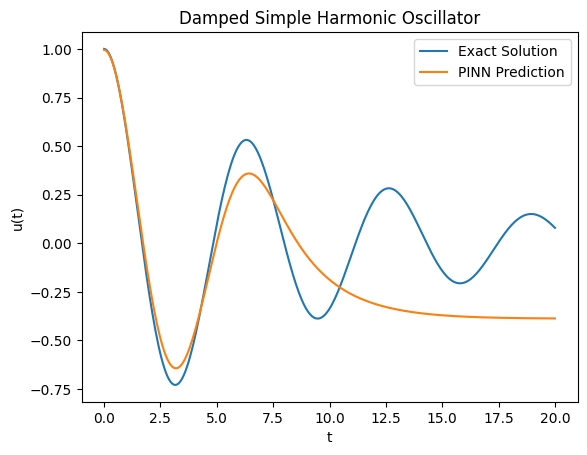

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def exact_solution(t, omega=1.0, beta=0.1):
    omega_d = np.sqrt(omega**2 - beta**2)
    return np.exp(-beta * t) * (
        np.cos(omega_d * t) + (beta / omega_d) * np.sin(omega_d * t)
    )

# Evaluation points
t_test = torch.linspace(0, 20, 300).view(-1,1)
t_test_np = t_test.numpy().flatten()

# PINN prediction
with torch.no_grad():
    u_pred = pinn.forward(t_test).cpu().numpy().flatten()

# Exact solution
u_exact = exact_solution(t_test_np, omega=1.0, beta=0.1)

# Plot
plt.figure()
plt.plot(t_test_np, u_exact)
plt.plot(t_test_np, u_pred)
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend(["Exact Solution", "PINN Prediction"])
plt.title("Damped Simple Harmonic Oscillator")
plt.show()


let's make a larger dataset using the anlytical known solution.

In [ ]:
#PINN for SHM
# we will modify the previos code with a new definition of physics loss and a new definition of second derivative
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim
import numpy as np


class PINN(nn.Module):
    def __init__(self,omega,beta):
        super().__init__()
        self.omega = omega
        self.beta = beta
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def build_model(self):
        return nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.model(x)


    def derivative(self, y, x):
        return grad(
            outputs=y,
            inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]

    def second_derivative(self, y, x):
        du_dx = self.derivative(y, x)
        u_xx = self.derivative(du_dx, x)
        return u_xx

    def physics_loss(self, x):
        x = x.requires_grad_(True)
        u = self.forward(x)
        du_dt = self.derivative(u, x)
        d2u_dt2 = self.derivative(du_dt, x)

        beta = self.beta      # damping coefficient
        omega = self.omega    # natural frequency

        # Residual of damped SHM equation
        residual = d2u_dt2 + 2 * beta * du_dt + omega**2 * u

        # Physics loss = MSE of residual
        return torch.mean(residual**2)

    def supervised_loss(self, x_data, u_data):
        u_pred = self.forward(x_data)
        return torch.mean((u_pred - u_data)**2)



    def train_step(self, x_phys, x_data, u_data,
               lambda_phys=1.0):
        self.optimizer.zero_grad()

        loss_phys = self.physics_loss(x_phys)
        loss_data = self.supervised_loss(x_data, u_data)

        loss = loss_data + lambda_phys * loss_phys

        loss.backward()
        self.optimizer.step()

        return {
            "total": loss.item(),
            "data": loss_data.item(),
            "physics": loss_phys.item()
        }




In [ ]:
def exact_solution(t, omega=1.0, beta=0.1):
    omega_d = np.sqrt(omega**2 - beta**2)
    return np.exp(-beta * t) * (
        np.cos(omega_d * t) + (beta / omega_d) * np.sin(omega_d * t)
    )


t_data = torch.linspace(0, 10, 30).view(-1,1)
u_data = torch.tensor(
    exact_solution(t_data.numpy(), omega=1.0, beta=0.1),
    dtype=torch.float32
).view(-1,1)


x_phys = torch.linspace(0, 20, 200).view(-1,1)

pinn = PINN(omega=1.0, beta=0.1)

for epoch in range(10000):
    losses = pinn.train_step(
        x_phys=x_phys,
        x_data=t_data,
        u_data=u_data,
        lambda_phys=1 # this is an important parameter
    )

    if epoch % 500 == 0:
        print(epoch, losses)


0 {'total': 0.27463534474372864, 'data': 0.26385948061943054, 'physics': 0.010775878094136715}
500 {'total': 0.04777849093079567, 'data': 0.037390027195215225, 'physics': 0.010388464666903019}
1000 {'total': 0.030344564467668533, 'data': 0.023268213495612144, 'physics': 0.007076350040733814}
1500 {'total': 0.018367422744631767, 'data': 0.00920323096215725, 'physics': 0.009164191782474518}
2000 {'total': 0.015860816463828087, 'data': 0.007050472777336836, 'physics': 0.008810343220829964}
2500 {'total': 0.014561859890818596, 'data': 0.006058964412659407, 'physics': 0.008502895012497902}
3000 {'total': 0.013687336817383766, 'data': 0.005551473703235388, 'physics': 0.008135862648487091}
3500 {'total': 0.017505928874015808, 'data': 0.009058156050741673, 'physics': 0.008447772823274136}
4000 {'total': 0.01126283872872591, 'data': 0.0037594970781356096, 'physics': 0.007503341883420944}
4500 {'total': 0.010574638843536377, 'data': 0.0031941758934408426, 'physics': 0.007380462717264891}
5000 {'

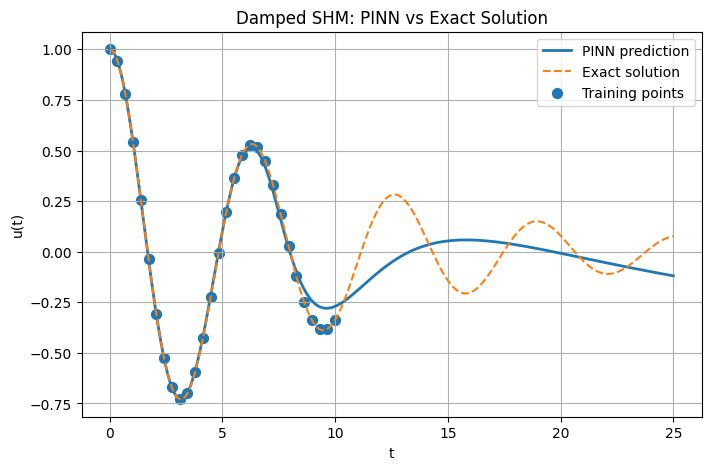

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Dense grid for plotting
t_plot = torch.linspace(0, 25, 400).view(-1,1)

# PINN prediction
with torch.no_grad():
    u_pinn = pinn.forward(t_plot).cpu().numpy().flatten()

t_plot_np = t_plot.numpy().flatten()
u_exact_plot = exact_solution(t_plot_np, omega=1.0, beta=0.1)

t_data_np = t_data.numpy().flatten()
u_data_np = u_data.numpy().flatten()


plt.figure(figsize=(8,5))

# PINN learned solution
plt.plot(t_plot_np, u_pinn, linewidth=2)

# Exact solution
plt.plot(t_plot_np, u_exact_plot, linestyle="--")

# Supervised training points
plt.scatter(t_data_np, u_data_np, s=50)

plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped SHM: PINN vs Exact Solution")

plt.legend([
    "PINN prediction",
    "Exact solution",
    "Training points"
])

plt.grid(True)
plt.show()


In [ ]:
# i think we can do better let's try more learning loops
def exact_solution(t, omega=1.0, beta=0.1):
    omega_d = np.sqrt(omega**2 - beta**2)
    return np.exp(-beta * t) * (
        np.cos(omega_d * t) + (beta / omega_d) * np.sin(omega_d * t)
    )


t_data = torch.linspace(0, 10, 30).view(-1,1)
u_data = torch.tensor(
    exact_solution(t_data.numpy(), omega=1.0, beta=0.1),
    dtype=torch.float32
).view(-1,1)


x_phys = torch.linspace(0, 20, 200).view(-1,1)

pinn = PINN(omega=1.0, beta=0.1)

for epoch in range(20000):
    losses = pinn.train_step(
        x_phys=x_phys,
        x_data=t_data,
        u_data=u_data,
        lambda_phys=1 # this is an important parameter
    )

    if epoch % 500 == 0:
        print(epoch, losses)


0 {'total': 0.2857895791530609, 'data': 0.2648395001888275, 'physics': 0.0209500789642334}
500 {'total': 0.026533247902989388, 'data': 0.018968705087900162, 'physics': 0.0075645423494279385}
1000 {'total': 0.016877077519893646, 'data': 0.007871279492974281, 'physics': 0.00900579709559679}
1500 {'total': 0.014466017484664917, 'data': 0.005999870598316193, 'physics': 0.008466146886348724}
2000 {'total': 0.013295872136950493, 'data': 0.005189189221709967, 'physics': 0.008106682449579239}
2500 {'total': 0.02495461143553257, 'data': 0.013628615066409111, 'physics': 0.011325996369123459}
3000 {'total': 0.011928699910640717, 'data': 0.004176688380539417, 'physics': 0.007752011530101299}
3500 {'total': 0.011516725644469261, 'data': 0.003927791025489569, 'physics': 0.00758893508464098}
4000 {'total': 0.01115148700773716, 'data': 0.0036843090783804655, 'physics': 0.007467178162187338}
4500 {'total': 0.01085682213306427, 'data': 0.003524612868204713, 'physics': 0.007332209497690201}
5000 {'total'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Dense grid for plotting
t_plot = torch.linspace(0, 25, 400).view(-1,1)

# PINN prediction
with torch.no_grad():
    u_pinn = pinn.forward(t_plot).cpu().numpy().flatten()

t_plot_np = t_plot.numpy().flatten()
u_exact_plot = exact_solution(t_plot_np, omega=1.0, beta=0.1)

t_data_np = t_data.numpy().flatten()
u_data_np = u_data.numpy().flatten()


plt.figure(figsize=(8,5))

# PINN learned solution
plt.plot(t_plot_np, u_pinn, linewidth=2)

# Exact solution
plt.plot(t_plot_np, u_exact_plot, linestyle="--")

# Supervised training points
plt.scatter(t_data_np, u_data_np, s=50)

plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Damped SHM: PINN vs Exact Solution")

plt.legend([
    "PINN prediction",
    "Exact solution",
    "Training points"
])

plt.grid(True)
plt.show()


# **Week 2**

In [2]:
# first let's install pybamm
!pip install pybamm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.8/849.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.0 MB/s eta 0:00:00


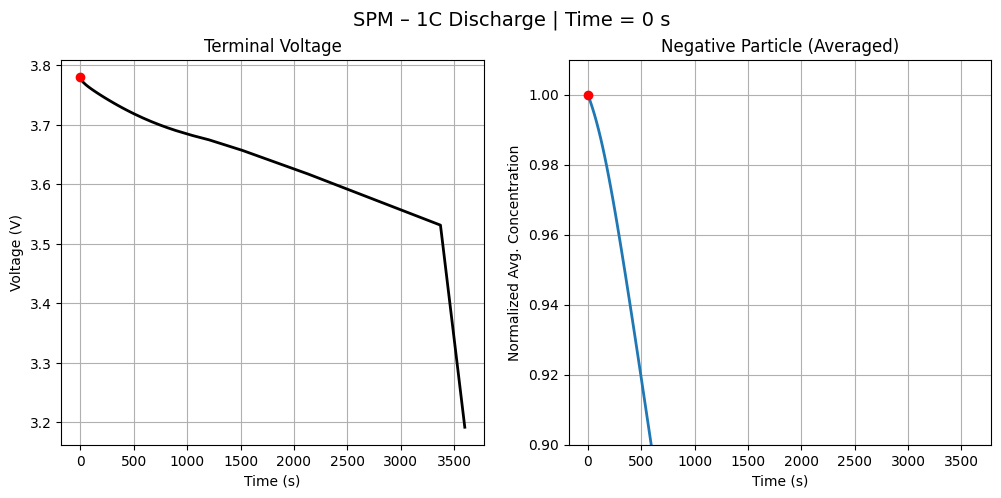

In [12]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

model = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment(["Discharge at 1C for 1 hour"])

sim = pybamm.Simulation(model, experiment=experiment)
solution = sim.solve()

time = solution.t
voltage = solution["Terminal voltage [V]"](time)

# Particle-averaged negative concentration (FIXED)
c_avg = solution[
    "X-averaged negative particle concentration [mol.m-3]"
].entries.mean(axis=0)

# Normalize for clarity
c_avg_norm = c_avg / c_avg[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# -------- Voltage vs Time --------
ax1.plot(time, voltage, color="black", lw=2)
v_marker = ax1.plot([time[0]], [voltage[0]], "ro")[0]

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V)")
ax1.set_title("Terminal Voltage")
ax1.grid(True)

# -------- Particle-averaged concentration --------
ax2.plot(time, c_avg_norm, lw=2)
c_marker = ax2.plot([time[0]], [c_avg_norm[0]], "ro")[0]

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Normalized Avg. Concentration")
ax2.set_title("Negative Particle (Averaged)")
ax2.set_ylim(0.9, 1.01)
ax2.grid(True)

suptitle = fig.suptitle("", fontsize=14)

def update(frame):
    t = time[frame]

    v_marker.set_data([t], [voltage[frame]])
    c_marker.set_data([t], [c_avg_norm[frame]])

    suptitle.set_text(f"SPM – 1C Discharge | Time = {int(t)} s")
    return v_marker, c_marker, suptitle

ani = FuncAnimation(
    fig,
    update,
    frames=len(time),
    interval=50,
    blit=False
)

HTML(ani.to_jshtml())


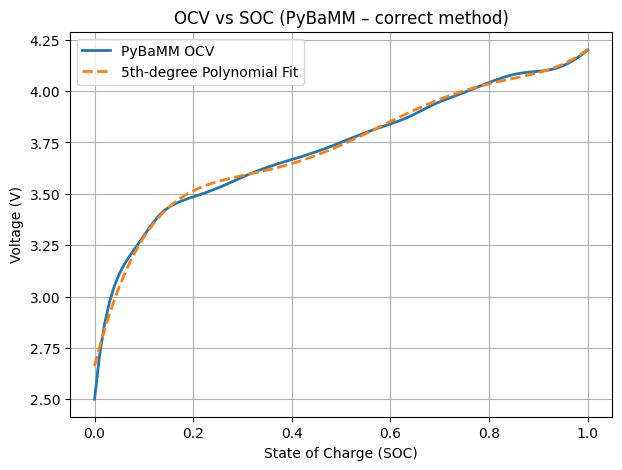

Voltage at SOC = 0.2: 3.5146530119043047
Voltage at SOC = 0.5: 3.737513904297753
Voltage at SOC = 0.8: 4.035518734037103


In [17]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

soc_grid = np.linspace(0.0, 1.0, 100)
ocv_values = []

for soc in soc_grid:
    # Model
    model = pybamm.lithium_ion.SPM()

    # Parameters
    param = pybamm.ParameterValues("Chen2020")

    # OCV condition: rest (no current)
    experiment = pybamm.Experiment(["Rest for 1 hour"])

    # Simulation
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
        experiment=experiment
    )

    # THIS IS THE CORRECT WAY TO SET SOC
    sol = sim.solve(initial_soc=soc)

    # Extract OCV (last time point)
    ocv = sol["Terminal voltage [V]"].entries[-1]
    ocv_values.append(ocv)

ocv_values = np.array(ocv_values)

coeffs = np.polyfit(soc_grid, ocv_values, deg=5)
ocv_poly = np.poly1d(coeffs)

def voltage_from_soc(soc):
    soc = np.clip(soc, 0.0, 1.0)
    return ocv_poly(soc)

plt.figure(figsize=(7, 5))
plt.plot(soc_grid, ocv_values, label="PyBaMM OCV", lw=2)
plt.plot(soc_grid, ocv_poly(soc_grid), "--", label="5th-degree Polynomial Fit", lw=2)
plt.xlabel("State of Charge (SOC)")
plt.ylabel("Voltage (V)")
plt.title("OCV vs SOC (PyBaMM – correct method)")
plt.grid(True)
plt.legend()
plt.show()

print("Voltage at SOC = 0.2:", voltage_from_soc(0.2))
print("Voltage at SOC = 0.5:", voltage_from_soc(0.5))
print("Voltage at SOC = 0.8:", voltage_from_soc(0.8))
